In [3]:
!pip install --upgrade adlfs fsspec azure-identity


  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2026.1.0 which is incompatible.
s3fs 2024.6.1 requires fsspec==2024.6.1.*, but you have fsspec 2026.1.0 which is incompatible.


# Load Data (From Azure account storage)

In [1]:
import pandas as pd

path = (
    "abfss://silver@stfraudeltproduksouth.dfs.core.windows.net/"
    "credit_card/part-00000-578b43b8-99c7-4a03-99a6-5f7952a71c16-c000.csv"
)

df = pd.read_csv(
    path,
    storage_options={
        "account_name": "stfraudeltproduksouth",
        "anon": False
    }
)

df.head()
from azure.identity import DefaultAzureCredential
from adlfs import AzureBlobFileSystem


DefaultAzureCredential failed to retrieve a token from the included credentials.
Attempted credentials:
	EnvironmentCredential: EnvironmentCredential authentication unavailable. Environment variables are not fully configured.
Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot this issue.
	WorkloadIdentityCredential: WorkloadIdentityCredential authentication unavailable. The workload options are not fully configured. See the troubleshooting guide for more information: https://aka.ms/azsdk/python/identity/workloadidentitycredential/troubleshoot. Missing required arguments: 'tenant_id', 'client_id', 'token_file_path'.
	ManagedIdentityCredential: ManagedIdentityCredential authentication unavailable, no response from the IMDS endpoint.
	SharedTokenCacheCredential: SharedTokenCacheCredential authentication unavailable. No accounts were found in the cache.
	VisualStudioCodeCredential: VisualStudioCodeCredential requires the 'azure-identity-broker' pa

In [2]:
from azure.identity import DefaultAzureCredential
from adlfs import AzureBlobFileSystem
import pandas as pd

credential = DefaultAzureCredential()

fs = AzureBlobFileSystem(
    account_name="stfraudeltproduksouth",
    credential=credential
)


In [3]:
file_path = "silver/credit_card/part-00000-578b43b8-99c7-4a03-99a6-5f7952a71c16-c000.csv"

with fs.open(file_path) as f:
    df = pd.read_csv(f)

df.head()


,time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,amount,fraud_label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,False
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,False
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,False
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,False
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,False


In [4]:
df.shape


(73299, 31)

In [5]:
df.isnull().sum().head()


time    49841
V1          0
V2          0
V3          0
V4          0
dtype: int64

In [6]:
df["fraud_label"].value_counts()


fraud_label
False    73121
True       178
Name: count, dtype: int64

In [7]:
df["fraud_label"].value_counts(normalize=True) * 100


fraud_label
False    99.757159
True      0.242841
Name: proportion, dtype: float64

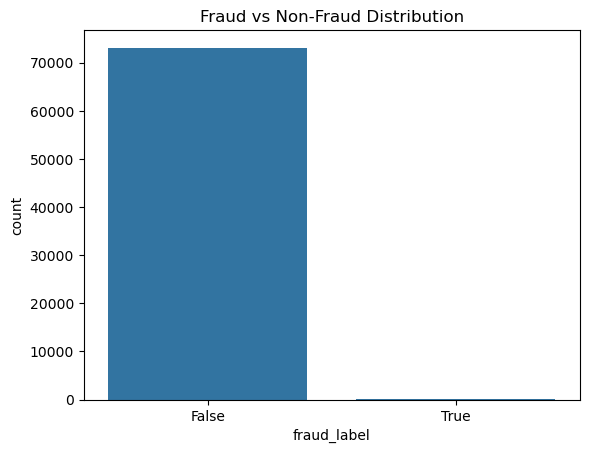

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="fraud_label", data=df)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()


In [10]:
# Check if the entire DataFrame has any missing values
print(f"Are there any missing values in the DataFrame? {df.isnull().any().any()}")

# Check if a specific column has any missing values
print(f"Are there any missing values in the 'Time' column? {df['time'].isnull().any()}")


Are there any missing values in the DataFrame? True
Are there any missing values in the 'Time' column? True


In [ ]:
df["amount"].describe()


count    73299.000000
mean        97.301583
std        270.166887
min          0.000000
25%          7.680000
50%         26.630000
75%         88.970000
max      19656.530000
Name: amount, dtype: float64

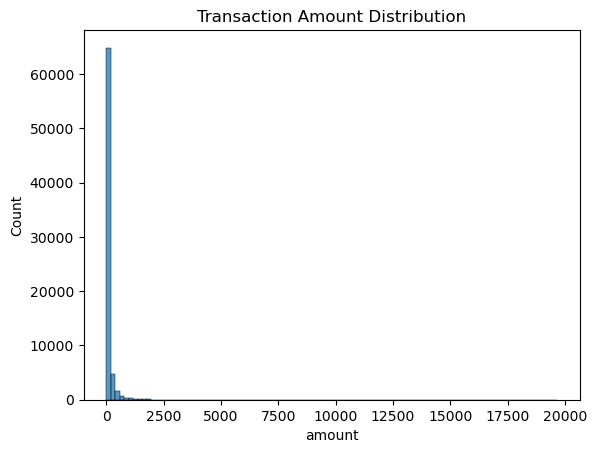

In [11]:
sns.histplot(df["amount"], bins=100)
plt.title("Transaction Amount Distribution")
plt.show()


In [12]:
X = df.drop(columns=["fraud_label"])
y = df["fraud_label"]


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=42
)


In [14]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    roc_auc_score
)

def evaluate_model(name, y_true, y_pred, y_prob):
    print(f"=== {name} ===")
    print(classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} – Confusion Matrix")
    plt.show()
    
    pr_auc = average_precision_score(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)
    
    print(f"PR-AUC: {pr_auc:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{name} – Precision-Recall Curve")
    plt.show()
    
    return pr_auc


=== Decision Tree ===
              precision    recall  f1-score   support

       False       1.00      0.98      0.99     21937
        True       0.12      0.87      0.21        53

    accuracy                           0.98     21990
   macro avg       0.56      0.93      0.60     21990
weighted avg       1.00      0.98      0.99     21990



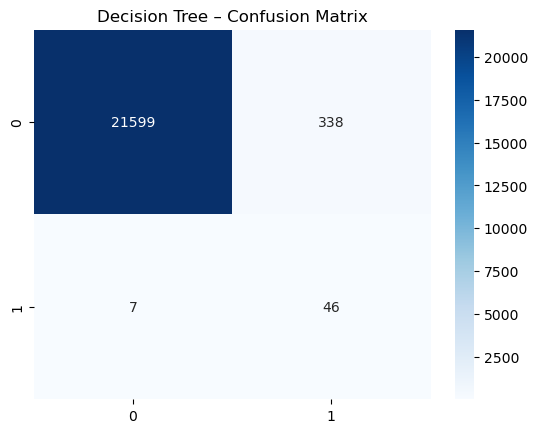

PR-AUC: 0.3276
ROC-AUC: 0.9314


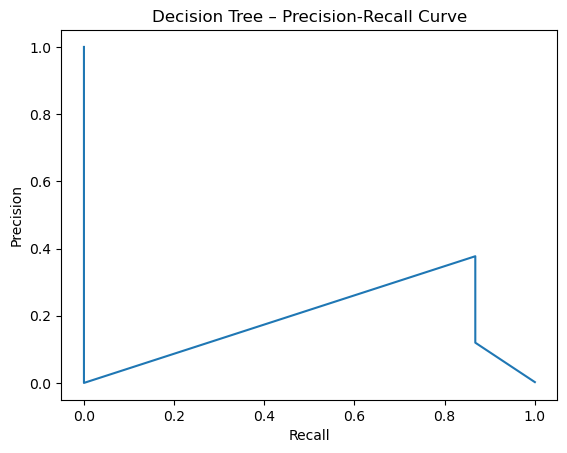

In [15]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    max_depth=6,
    class_weight="balanced",
    random_state=42
)

dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:, 1]

pr_dt = evaluate_model(
    "Decision Tree",
    y_test,
    y_pred_dt,
    y_prob_dt
)


=== Random Forest ===
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     21937
        True       0.94      0.83      0.88        53

    accuracy                           1.00     21990
   macro avg       0.97      0.92      0.94     21990
weighted avg       1.00      1.00      1.00     21990



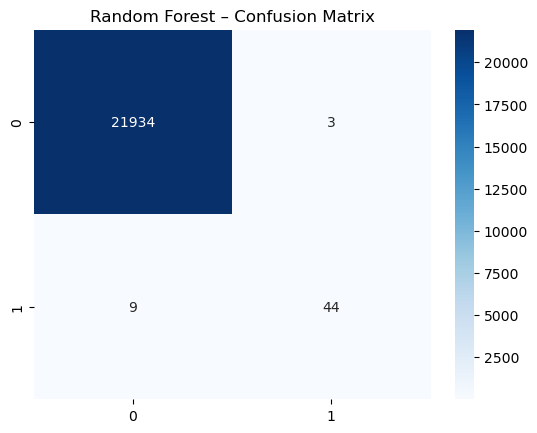

PR-AUC: 0.9075
ROC-AUC: 0.9982


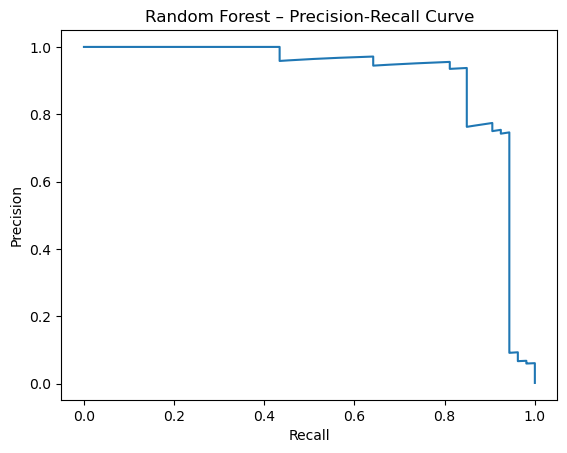

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

pr_rf = evaluate_model(
    "Random Forest",
    y_test,
    y_pred_rf,
    y_prob_rf
)


=== XGBoost ===
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     21937
        True       0.92      0.87      0.89        53

    accuracy                           1.00     21990
   macro avg       0.96      0.93      0.95     21990
weighted avg       1.00      1.00      1.00     21990



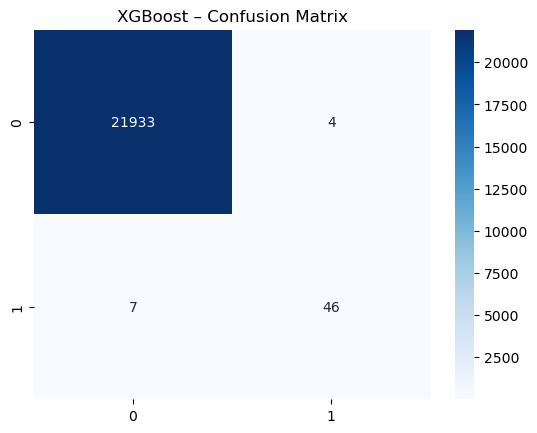

PR-AUC: 0.9366
ROC-AUC: 0.9975


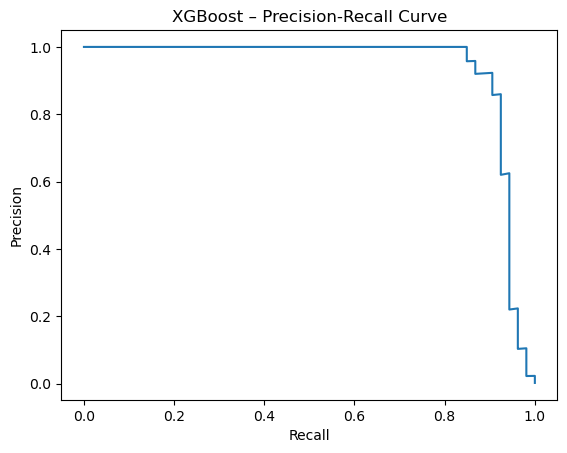

In [17]:
from xgboost import XGBClassifier

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    eval_metric="aucpr",
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

pr_xgb = evaluate_model(
    "XGBoost",
    y_test,
    y_pred_xgb,
    y_prob_xgb
)


In [18]:
import pandas as pd

results = pd.DataFrame({
    "Model": [
        #"Logistic Regression",
        "Decision Tree",
        "Random Forest",
        "XGBoost"
    ],
    "PR-AUC": [
        #pr_lr,
        pr_dt,
        pr_rf,
        pr_xgb
    ]
})

results.sort_values(by="PR-AUC", ascending=False)


,Model,PR-AUC
2,XGBoost,0.936601
1,Random Forest,0.907475
0,Decision Tree,0.327569


# Threshold tuning for best model (XGB)

In [19]:
y_scores = y_prob_xgb  # probabilities from XGBoost


## Compute precision–recall curve

In [20]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)


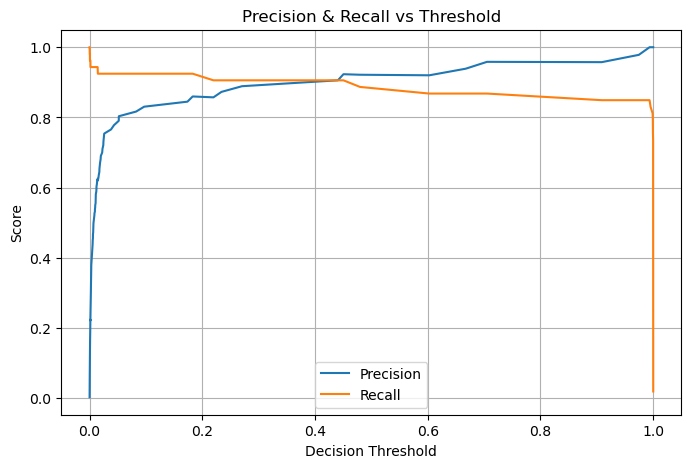

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


## Precision-constrained threshold

In [22]:
import numpy as np

MIN_PRECISION = 0.90

valid_idx = np.where(precision[:-1] >= MIN_PRECISION)[0]

best_idx = valid_idx[np.argmax(recall[valid_idx])]
best_threshold = thresholds[best_idx]

best_threshold


np.float32(0.44051197)

In [ ]:
# Apply the tuned threshold
y_pred_tuned = (y_scores >= best_threshold).astype(int)


Threshold: 0.44051197
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     21937
        True       0.91      0.91      0.91        53

    accuracy                           1.00     21990
   macro avg       0.95      0.95      0.95     21990
weighted avg       1.00      1.00      1.00     21990



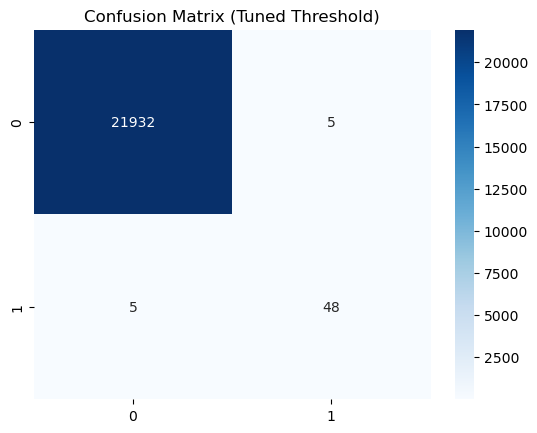

In [ ]:
# Re-evaluating with tuned threshold

from sklearn.metrics import classification_report, confusion_matrix

print("Threshold:", best_threshold)
print(classification_report(y_test, y_pred_tuned))

cm = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Tuned Threshold)")
plt.show()


# Cost-sensitive evaluation

In [25]:
COST_FN = 10   # missed fraud is very expensive
COST_FP = 1    # customer friction / investigation cost
COST_TP = 0    # catching fraud is good
COST_TN = 0


In [26]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(
    y_test,
    y_pred_tuned
).ravel()

tn, fp, fn, tp


(np.int64(21932), np.int64(5), np.int64(5), np.int64(48))

In [27]:
total_cost = (
    fn * COST_FN +
    fp * COST_FP +
    tp * COST_TP +
    tn * COST_TN
)

total_cost


np.int64(55)

In [28]:
import numpy as np

costs = []

for t in thresholds:
    y_pred_t = (y_scores >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    
    cost = (
        fn * COST_FN +
        fp * COST_FP
    )
    
    costs.append(cost)


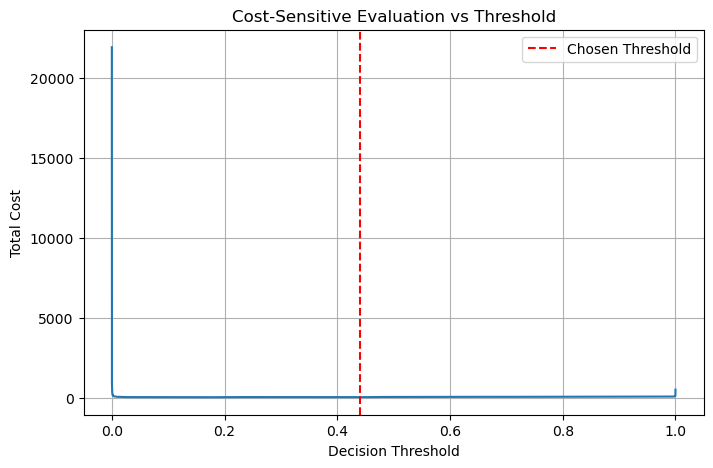

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, costs)
plt.axvline(best_threshold, color="red", linestyle="--", label="Chosen Threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("Total Cost")
plt.title("Cost-Sensitive Evaluation vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


In [30]:
best_cost_idx = np.argmin(costs)
best_cost_threshold = thresholds[best_cost_idx]

best_cost_threshold


np.float32(0.18291892)

In [31]:
y_pred_cost_opt = (y_scores >= best_cost_threshold).astype(int)

print("Cost-optimal threshold:", best_cost_threshold)
print(classification_report(y_test, y_pred_cost_opt))


Cost-optimal threshold: 0.18291892
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     21937
        True       0.86      0.92      0.89        53

    accuracy                           1.00     21990
   macro avg       0.93      0.96      0.95     21990
weighted avg       1.00      1.00      1.00     21990



# COMPARING DECISION POLICIES

In [32]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_policy(name, y_true, y_scores, threshold):
    y_pred = (y_scores >= threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    print(f"\n=== {name} ===")
    print(f"Threshold: {threshold:.4f}")
    print(classification_report(y_true, y_pred))
    
    cost = fn * COST_FN + fp * COST_FP
    print(f"Total Cost: {cost}")
    
    return {
        "Policy": name,
        "Threshold": threshold,
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "TN": tn,
        "Total_Cost": cost
    }


In [33]:
policy_results = []

# 1. Default threshold
policy_results.append(
    evaluate_policy(
        "Default (0.5)",
        y_test,
        y_scores,
        0.5
    )
)

# 2. Precision-constrained threshold
policy_results.append(
    evaluate_policy(
        "Precision-Constrained",
        y_test,
        y_scores,
        best_threshold
    )
)

# 3. Cost-optimal threshold
policy_results.append(
    evaluate_policy(
        "Cost-Optimal",
        y_test,
        y_scores,
        best_cost_threshold
    )
)



=== Default (0.5) ===
Threshold: 0.5000
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     21937
        True       0.92      0.87      0.89        53

    accuracy                           1.00     21990
   macro avg       0.96      0.93      0.95     21990
weighted avg       1.00      1.00      1.00     21990

Total Cost: 74

=== Precision-Constrained ===
Threshold: 0.4405
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     21937
        True       0.91      0.91      0.91        53

    accuracy                           1.00     21990
   macro avg       0.95      0.95      0.95     21990
weighted avg       1.00      1.00      1.00     21990

Total Cost: 55

=== Cost-Optimal ===
Threshold: 0.1829
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     21937
        True       0.86      0.92      0.89        53

    accuracy          

In [34]:
policy_comparison = pd.DataFrame(policy_results)
policy_comparison


,Policy,Threshold,TP,FP,FN,TN,Total_Cost
0,Default (0.5),0.500000,46,4,7,21933,74
1,Precision-Constrained,0.440512,48,5,5,21932,55
2,Cost-Optimal,0.182919,49,8,4,21929,48


# FEATURE IMPORTANCE & SHAP

## Tree-based feature importance (XGBoost)

In [35]:
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb.feature_importances_
}).sort_values(by="Importance", ascending=False)

importances.head(10)


,Feature,Importance
14,V14,0.541644
29,amount,0.055498
13,V13,0.042753
5,V5,0.035986
4,V4,0.035432
17,V17,0.029975
10,V10,0.024691
28,V28,0.024626
23,V23,0.023566
9,V9,0.020359


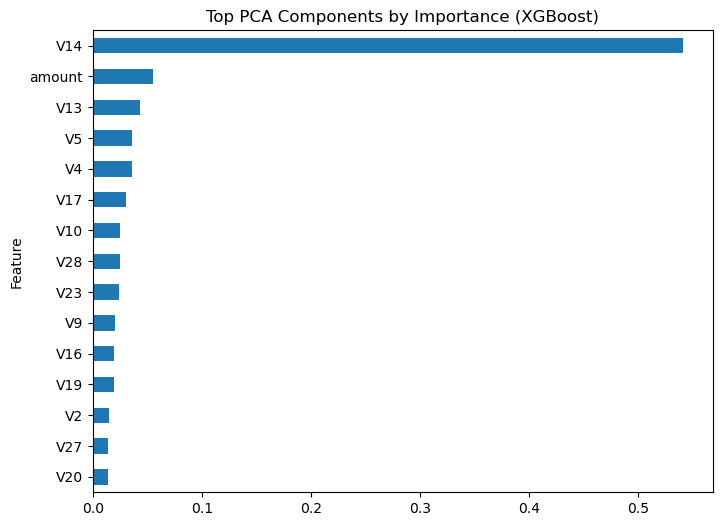

In [36]:
importances.head(15).plot(
    x="Feature",
    y="Importance",
    kind="barh",
    figsize=(8, 6),
    legend=False
)
plt.title("Top PCA Components by Importance (XGBoost)")
plt.gca().invert_yaxis()
plt.show()


In [37]:
import numpy as np
import pandas as pd
import shap

print(np.__version__)
print(shap.__version__)


2.3.5
0.50.0


In [40]:
import shap


explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)



In [ ]:
print(shap_values)

[[-0.26137578  0.10810076 -0.04416325 ... -0.25468165 -0.08727384
   0.45080835]
 [ 0.08720516 -0.18727536 -0.2959834  ... -0.05049667 -0.11463527
   1.2736639 ]
 [ 0.03016649 -0.04971608 -0.20442632 ... -0.06748857 -0.01351995
  -0.5871282 ]
 ...
 [ 0.02627647 -0.06423042 -0.20668024 ... -0.15915135  0.02600945
  -0.6169763 ]
 [ 0.02901245 -0.04560132 -0.24692693 ... -0.01621943 -0.00694149
  -1.14377   ]
 [ 0.03032969 -0.08247782 -0.11214858 ... -0.07266578 -0.00561577
  -0.94492596]]


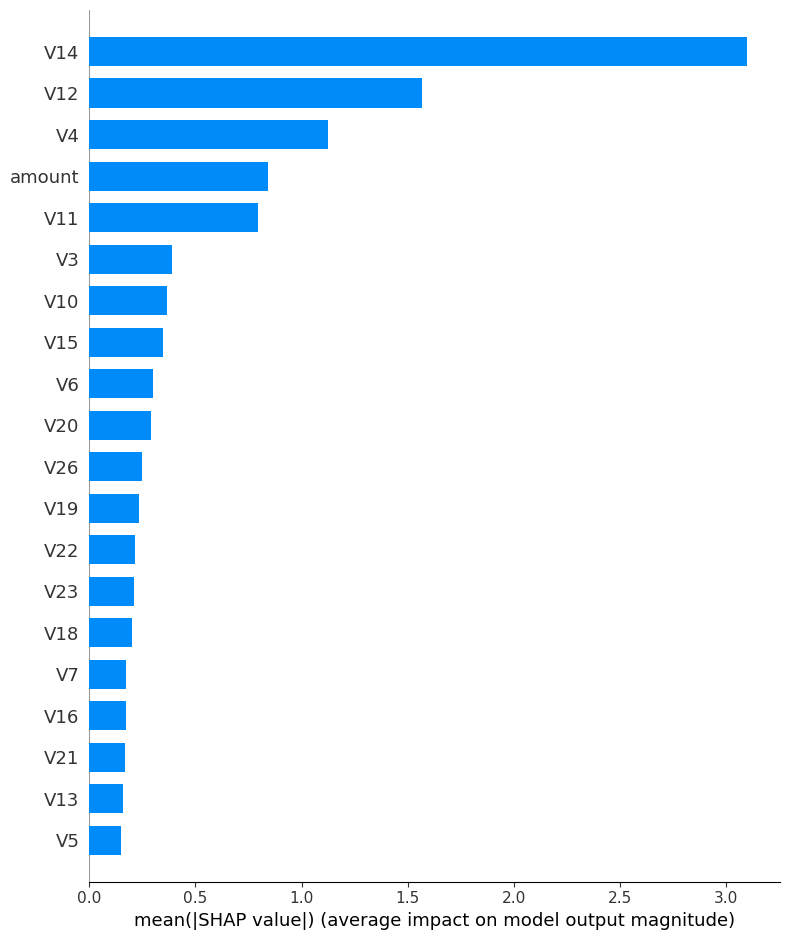

In [44]:
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="bar"
)


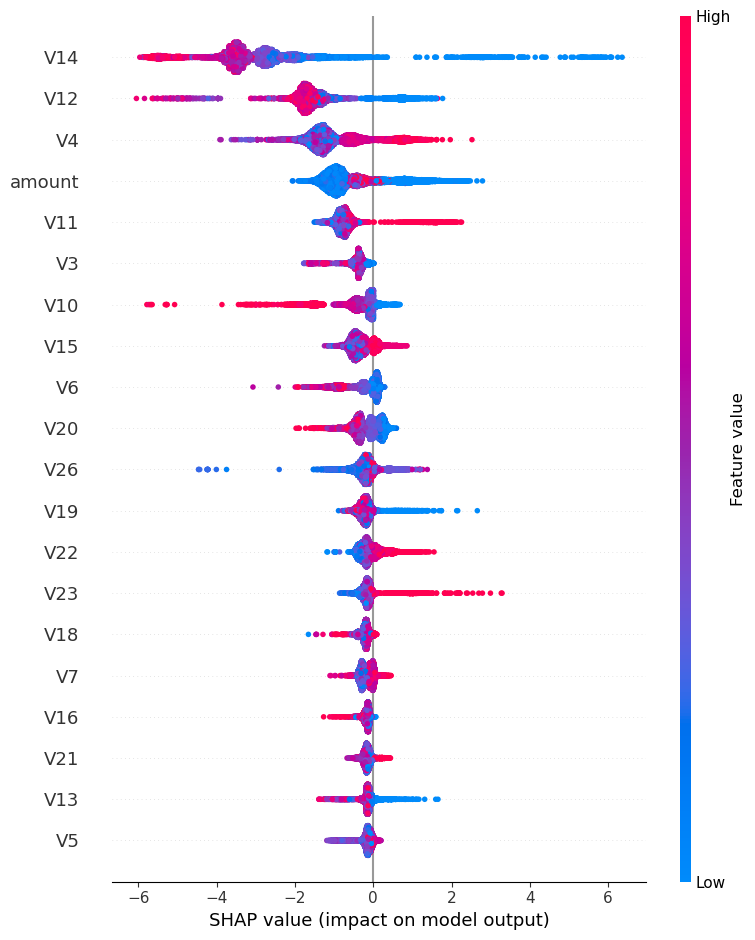

In [42]:
shap.summary_plot(
    shap_values,
    X_test
)
